In [1]:
import numpy as np
import pandas as pd
from shutil import copyfile
from matplotlib import gridspec
from astropy.io import fits
from astropy import wcs
import collections
from IPython.display import Image
from astropy.table import Table
from spec_tools import Source_present, Get_Sensitivity,Mag
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from glob import glob
import seaborn as sea
import os
from grizli import model as griz_model
from spec_extract import Stack
from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'
if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [2]:
S_v4 = pd.read_pickle('../dataframes/GS_v4.3_uvj.pkl')
N_v4 = pd.read_pickle('../dataframes/GN_v4.3_uvj.pkl')

S_zg = pd.read_pickle('../dataframes/GS_uvj_z_grism_v2.pkl')
N_zg = pd.read_pickle('../dataframes/GN_uvj_z_grism_v2.pkl')

In [3]:
def Color(band1, band2):
    m1=-2.5*np.log10(band1)
    m2=-2.5*np.log10(band2)
    return m1-m2

N_UV_v4 = Color(N_v4.U,N_v4.V)
N_VJ_v4 = Color(N_v4.V,N_v4.J)

S_UV_v4 = Color(S_v4.U,S_v4.V)
S_VJ_v4 = Color(S_v4.V,S_v4.J)

N_UV_zg = Color(N_zg.U,N_zg.V)
N_VJ_zg = Color(N_zg.V,N_zg.J)

S_UV_zg = Color(S_zg.U,S_zg.V)
S_VJ_zg = Color(S_zg.V,S_zg.J)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
OII = 3730
Hb = 4863
OIII = 5008
Ha = 6564

In [36]:
z = 1.3
#lims 8000, 16500, redshift lims 1.14 < z < 1.54 for all, 1.14 < z < 2.3 for R23
print(OII * (1+z), OIII * (1+z), Ha * (1+z))

8579.0 11518.4 15097.199999999999


In [44]:
N_UV_v4 = Color(N_v4.query('1.14 < z < 2.3 and lmass > 8.').U,N_v4.query('1.14 < z < 2.3 and lmass > 8.').V)
N_VJ_v4 = Color(N_v4.query('1.14 < z < 2.3 and lmass > 8.').V,N_v4.query('1.14 < z < 2.3 and lmass > 8.').J)

S_UV_v4 = Color(S_v4.query('1.14 < z < 2.3 and lmass > 8.').U,S_v4.query('1.14 < z < 2.3 and lmass > 8.').V)
S_VJ_v4 = Color(S_v4.query('1.14 < z < 2.3 and lmass > 8.').V,S_v4.query('1.14 < z < 2.3 and lmass > 8.').J)

SQ_v4=[]
SSF_v4 = []
NQ_v4=[]
NSF_v4 = []

for i in N_UV_v4.index:
    if N_UV_v4[i]>=0.88*N_VJ_v4[i]+0.59 and N_UV_v4[i]>1.382 and N_VJ_v4[i]<1.65:
        NQ_v4.append(i)
    else:
        NSF_v4.append(i)
        
for i in S_UV_v4.index:
    if S_UV_v4[i]>=0.88*S_VJ_v4[i]+0.59 and S_UV_v4[i]>1.382 and S_VJ_v4[i]<1.65:
        SQ_v4.append(i)
    else:
        SSF_v4.append(i)  

N_UV_zg = Color(N_zg.query('1.14 < z50 < 2.3 and lmass > 8.').U,N_zg.query('1.14 < z50 < 2.3 and lmass > 8.').V)
N_VJ_zg = Color(N_zg.query('1.14 < z50 < 2.3 and lmass > 8.').V,N_zg.query('1.14 < z50 < 2.3 and lmass > 8.').J)

S_UV_zg = Color(S_zg.query('1.14 < z50 < 2.3 and lmass > 8.').U,S_zg.query('1.14 < z50 < 2.3 and lmass > 8.').V)
S_VJ_zg = Color(S_zg.query('1.14 < z50 < 2.3 and lmass > 8.').V,S_zg.query('1.14 < z50 < 2.3 and lmass > 8.').J)

SQ_zg=[]
SSF_zg = []
NQ_zg=[]
NSF_zg = []

for i in N_UV_zg.index:
    if N_UV_zg[i]>=0.88*N_VJ_zg[i]+0.59 and N_UV_zg[i]>1.382 and N_VJ_zg[i]<1.65:
        NQ_zg.append(i)
    else:
        NSF_zg.append(i)
for i in S_UV_zg.index:
    if S_UV_zg[i]>=0.88*S_VJ_zg[i]+0.59 and S_UV_zg[i]>1.382 and S_VJ_zg[i]<1.65:
        SQ_zg.append(i)
    else:
        SSF_zg.append(i)

[0, 2.5, 0.5, 2.5]

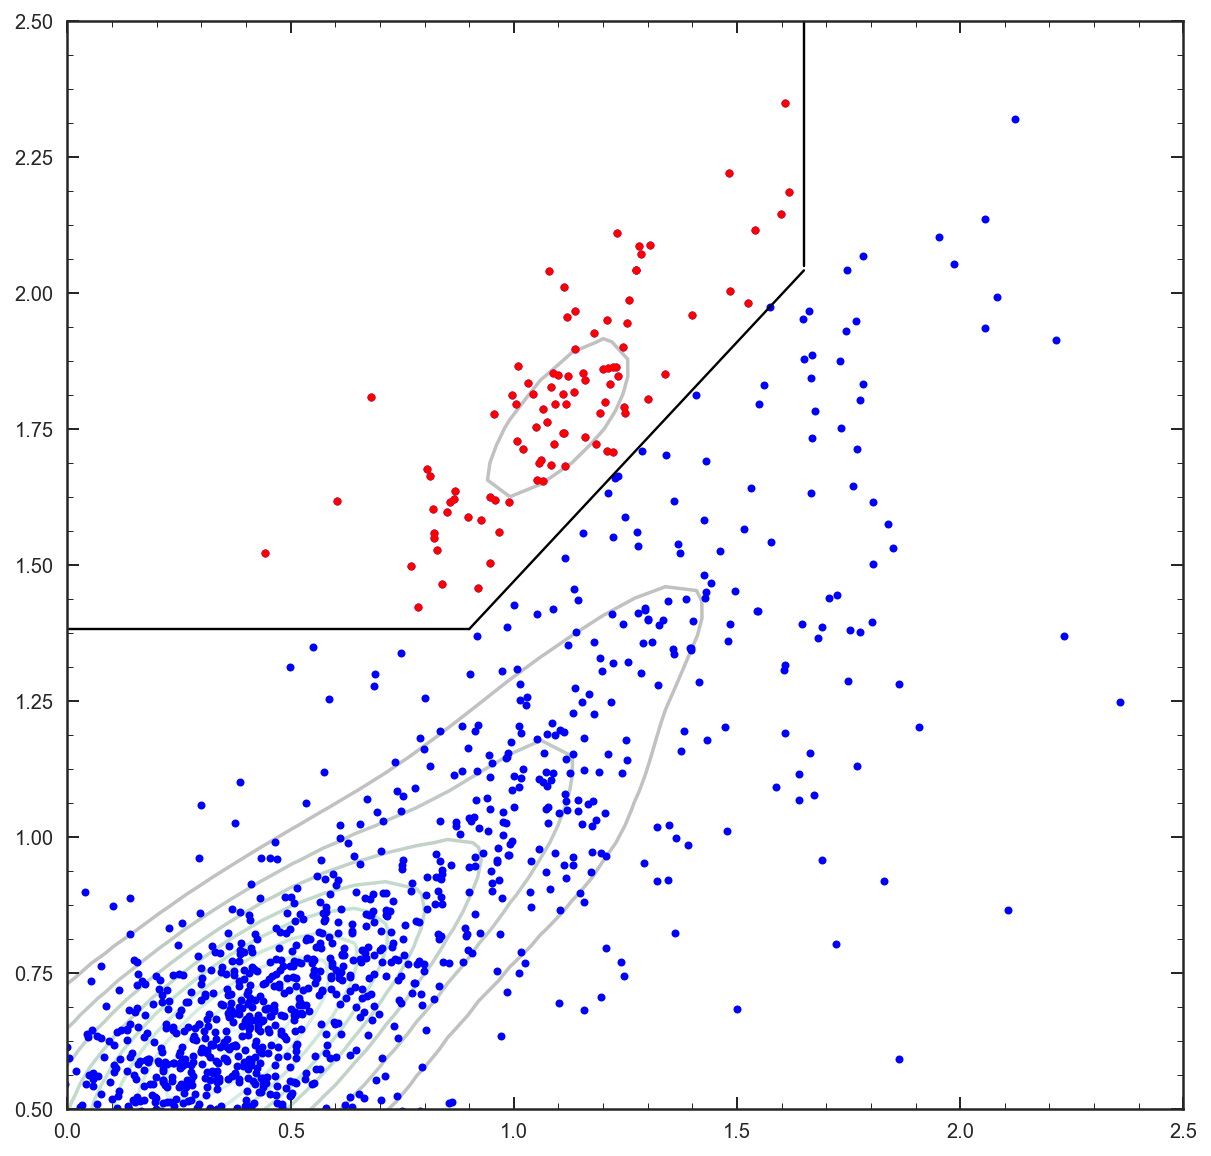

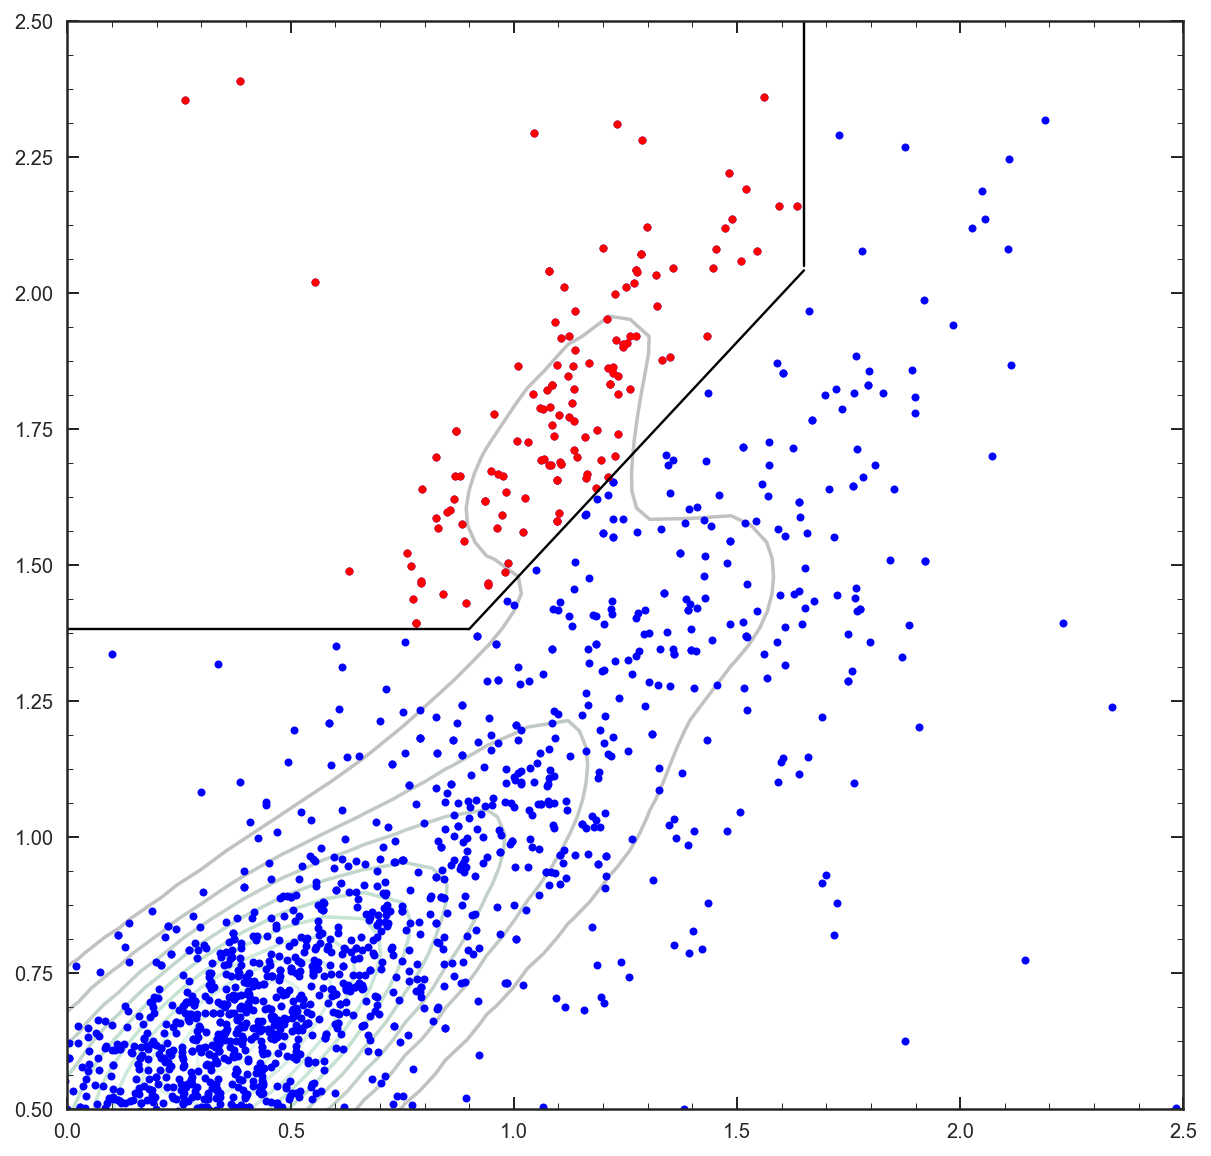

In [45]:
plt.figure(figsize=[10,10])
sea.kdeplot(np.append(S_VJ_v4,N_VJ_v4),np.append(S_UV_v4,N_UV_v4),alpha=0.3)

plt.plot(S_VJ_v4, S_UV_v4,'bo',ms=4)
plt.plot(N_VJ_v4, N_UV_v4,'bo',ms=4)

plt.plot(S_VJ_v4[SQ_v4], S_UV_v4[SQ_v4],'ro',ms=4)
plt.plot(N_VJ_v4[NQ_v4], N_UV_v4[NQ_v4],'ro',ms=4)

plt.plot([0,.9],[1.382,1.382],'k',lw=1.2)
plt.plot([1.65,1.65],[2.05,2.5],'k',lw=1.2)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=1.2)
plt.axis([0,2.5,.5,2.5])

#######################

plt.figure(figsize=[10,10])
sea.kdeplot(np.append(S_VJ_zg,N_VJ_zg),np.append(S_UV_zg,N_UV_zg),alpha=0.3)

plt.plot(S_VJ_zg, S_UV_zg,'bo',ms=4)
plt.plot(N_VJ_zg, N_UV_zg,'bo',ms=4)

plt.plot(S_VJ_zg[SQ_zg], S_UV_zg[SQ_zg],'ro',ms=4)
plt.plot(N_VJ_zg[NQ_zg], N_UV_zg[NQ_zg],'ro',ms=4)

plt.plot([0,.9],[1.382,1.382],'k',lw=1.2)
plt.plot([1.65,1.65],[2.05,2.5],'k',lw=1.2)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=1.2)
plt.axis([0,2.5,.5,2.5])

In [46]:
Nid_zg = N_zg.id[N_VJ_zg[NSF_zg].index].values
Nlmass_zg = N_zg.lmass[N_VJ_zg[NSF_zg].index].values


In [47]:
NIDS = np.repeat('00000', len(Nid_zg))
for i in range(len(Nid_zg)):
    NIDS[i] = str(Nid_zg[i])
    if len(NIDS[i]) < 5:
        NIDS[i] = '0' + NIDS[i]

In [48]:
rshift = np.zeros(len(NIDS))
rshift16 = np.zeros(len(NIDS))
rshift84 = np.zeros(len(NIDS))

OII_f = np.zeros(len(NIDS))
OIII_f = np.zeros(len(NIDS))
Hb_f= np.zeros(len(NIDS))
Ha_f= np.zeros(len(NIDS))


for i in range(len(NIDS)):
    file = glob('/Volumes/Vince_CLEAR/RELEASE_v2.0.0/*N*/*/Prep/*{0}.full.fits'.format(NIDS[i]))[0]
    dat = fits.open(file)
    linenums = [U for U in dat[0].header['LINE*']]
    rshift[i] = dat[1].header['Z50']
    rshift16[i] = dat[1].header['Z16']
    rshift84[i] = dat[1].header['Z84']
    
    for ii in linenums:
        if dat[0].header[ii] == 'OII':
            OII_f[i] = dat[0].header[ii.replace('LINE','FLUX')]
        if dat[0].header[ii] == 'OIII':
            OIII_f[i] = dat[0].header[ii.replace('LINE','FLUX')]
        if dat[0].header[ii] == 'Hb':
            Hb_f[i] = dat[0].header[ii.replace('LINE','FLUX')]
        if dat[0].header[ii] == 'Ha':
            Ha_f[i] = dat[0].header[ii.replace('LINE','FLUX')]

(array([946., 128.,  59.,  30.,  24.,   5.,   7.,  10.,   3.,   6.,   1.,
          1.,   0.,   0.,   1.,   0.,   0.,   3.,   0.,   0.,   0.,   0.,
          0.,   2.,   2.,   0.,   0.,   0.,   0.,   1.]),
 array([3.52785206e-04, 7.87717760e-02, 1.57190767e-01, 2.35609758e-01,
        3.14028749e-01, 3.92447739e-01, 4.70866730e-01, 5.49285721e-01,
        6.27704712e-01, 7.06123703e-01, 7.84542694e-01, 8.62961684e-01,
        9.41380675e-01, 1.01979967e+00, 1.09821866e+00, 1.17663765e+00,
        1.25505664e+00, 1.33347563e+00, 1.41189462e+00, 1.49031361e+00,
        1.56873260e+00, 1.64715159e+00, 1.72557058e+00, 1.80398957e+00,
        1.88240857e+00, 1.96082756e+00, 2.03924655e+00, 2.11766554e+00,
        2.19608453e+00, 2.27450352e+00, 2.35292251e+00]),
 <a list of 30 Patch objects>)

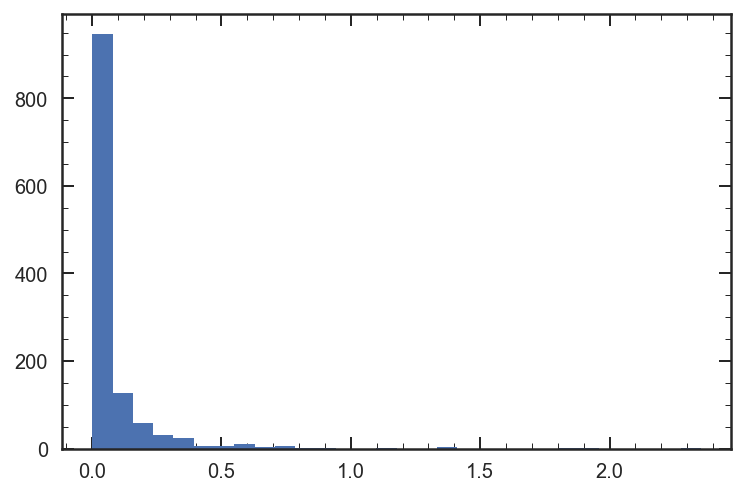

In [50]:
plt.hist(rshift84 - rshift16,bins = 30)

In [189]:
O32 = []
Omasses = []
OIDS = []
Oz = []
for i in range(len(Hb_f)):
    if OII_f[i] > 0 and OIII_f[i] > 0 and rshift84[i] - rshift16[i] < 0.01 and rshift[i] > 1.0:
        O32.append((OIII_f[i] / OII_f[i]))
        Omasses.append(Nlmass_zg[i])
        OIDS.append(NIDS[i])
        Oz.append(rshift[i])

Text(0,0.5,'log(O32)')

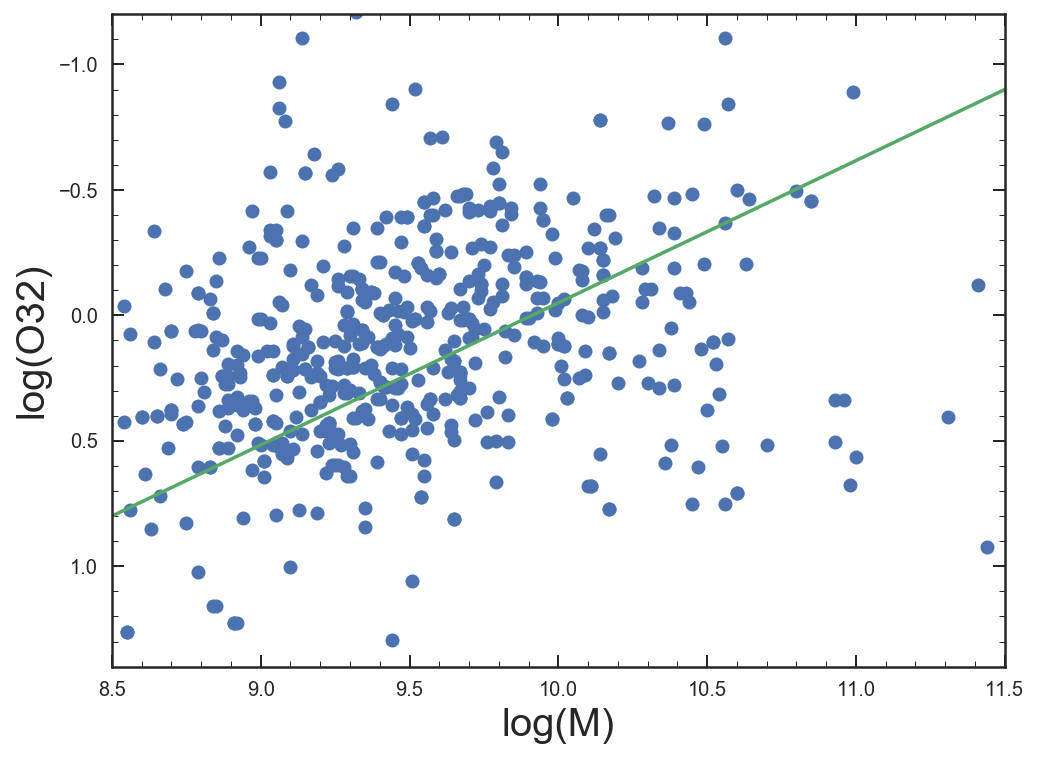

In [188]:
plt.figure(figsize=[8,6])
plt.plot(Omasses,np.log10(O32),'o')
plt.plot([8.5,11.5],[.8,-.9])
plt.ylim(1.4,-1.2)
plt.xlim(8.5,11.5)
plt.xlabel('log(M)', fontsize=20)
plt.ylabel('log(O32)', fontsize=20)

In [171]:
R23 = []
Rmasses = []
RIDS = []
Rz = []
for i in range(len(Hb_f)):
    if OII_f[i] > 0 and OIII_f[i] > 0 and Hb_f[i] > 0 and rshift84[i] - rshift16[i] < 0.01 and rshift[i] > 1.3:
        R23.append((OIII_f[i] + OII_f[i]) / Hb_f[i])
        Rmasses.append(Nlmass_zg[i])
        RIDS.append(NIDS[i])
        Rz.append(rshift[i])

Text(0,0.5,'log(R32)')

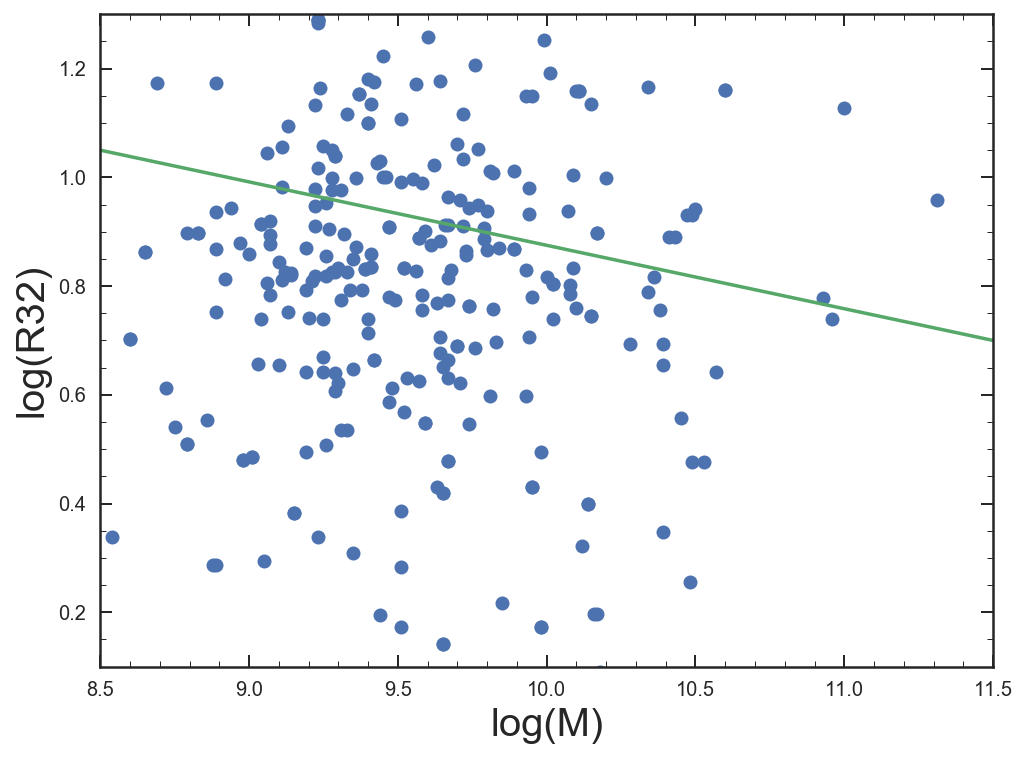

In [163]:
plt.figure(figsize=[8,6])
plt.plot(Rmasses,np.log10(R23),'o')
plt.plot([8.5,11.5],[1.05,0.7])
plt.ylim(0.1, 1.3)
plt.xlim(8.5,11.5)
plt.xlabel('log(M)', fontsize=20)
plt.ylabel('log(R32)', fontsize=20)

In [75]:
R23 = []
Rmasses = []
RIDS = []
Rz = []
for i in range(len(Hb_f)):
    if OII_f[i] > 0 and OIII_f[i] > 0 and Hb_f[i] > 0 and rshift84[i] - rshift16[i] < 0.003 and rshift[i] > 1.3:
        R23.append((OIII_f[i] + OII_f[i]) / Hb_f[i])
        Rmasses.append(Nlmass_zg[i])
        RIDS.append(NIDS[i])
        Rz.append(rshift[i])

In [164]:
def Stack(wv, fl , er):
    flgrid = np.transpose(fl)
    errgrid = np.transpose(er)
    weigrid = errgrid ** (-2)
    infmask = np.isinf(weigrid)
    weigrid[infmask] = 0
    ################

    stack, err = np.zeros([2, len(wv)])
    for i in range(len(wv)):
        stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
        err[i] = 1 / np.sqrt(np.sum(weigrid[i]))
    ################
    
    return stack, err

def Stack_g102_g141(rfwv, Bwv, Bfl, Ber, Rwv, Rfl, Rer, z):
    flgrid = np.zeros([2,len(rfwv)])
    ergrid = np.zeros([2,len(rfwv)])
    
    flgrid[0] = interp1d(Bwv / (1+z), Bfl,fill_value=0,bounds_error=False)(rfwv)
    flgrid[1] = interp1d(Rwv / (1+z), Rfl,fill_value=0,bounds_error=False)(rfwv)
    
    ergrid[0] = interp1d(Bwv / (1+z), Ber,fill_value=0,bounds_error=False)(rfwv)
    ergrid[1] = interp1d(Rwv / (1+z), Rer,fill_value=0,bounds_error=False)(rfwv)
    
    weigrid = ergrid ** (-2)
    infmask = np.isinf(weigrid)
    weigrid[infmask] = 0
    ################

    stack, err = np.zeros([2,len(rfwv)])
    for i in range(len(rfwv)):
        stack[i] = np.sum(flgrid.T[i] * weigrid.T[i]) / (np.sum(weigrid.T[i]))   
        err[i] = 1 / np.sqrt(np.sum(weigrid.T[i]))
    ################
    
    err[~(stack**2 > 0)] = 10
    stack[~(stack**2 > 0)] = 0
    
    return stack, err

In [216]:
rfwv = np.arange(2400,7000,12)
flxgrid = np.zeros([len(OIDS),len(rfwv)])
errgrid = np.zeros([len(OIDS),len(rfwv)])

IDX = [U for U in range(len(rfwv)) if 4000 < rfwv[U] < 6000]

for i in range(len(OIDS)):

    Bwv, Bfl, Ber = np.zeros([3,2])

    Rwv, Rfl, Rer = np.zeros([3,2])

    file = glob('/Volumes/Vince_CLEAR/RELEASE_v2.0.0/*N*/*/Prep/*{0}.1D.fits'.format(OIDS[i]))[0]
    dat = fits.open(file)

    try:
        Bwv = np.array(dat['G102'].data['wave']).T
        Bfl = np.array(dat['G102'].data['flux'] / dat['G102'].data['flat']).T
        Ber = np.array(dat['G102'].data['err'] / dat['G102'].data['flat']).T
        
        
        Bwv = Bwv[Bfl**2 > 0]
        Ber = Ber[Bfl**2 > 0]
        Bfl = Bfl[Bfl**2 > 0]

    except:
        print('no g102')

    try:
        Rwv = np.array(dat['G141'].data['wave']).T
        Rfl = np.array(dat['G141'].data['flux'] / dat['G141'].data['flat']).T
        Rer = np.array(dat['G141'].data['err'] / dat['G141'].data['flat']).T

        Rwv = Rwv[Rfl**2 > 0]
        Rer = Rer[Rfl**2 > 0]
        Rfl = Rfl[Rfl**2 > 0]

    except:
        print('no g141')

    st,er = Stack_g102_g141(rfwv, Bwv, Bfl, Ber, Rwv, Rfl, Rer, Oz[i])
    
#     errgrid[i] = er / np.trapz(st[IDX],rfwv[IDX])
#     flxgrid[i] = st / np.trapz(st[IDX],rfwv[IDX])
    
    errgrid[i] = er
    flxgrid[i] = st

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launche

no g102
no g141
no g141
no g141
no g141
no g141
no g141
no g102
no g102
no g141
no g141
no g141
no g141
no g102
no g102
no g141
no g141
no g141
no g141
no g102
no g102


In [217]:
stack,error = Stack(rfwv,flxgrid,errgrid)

(0.00035, 0.0011)

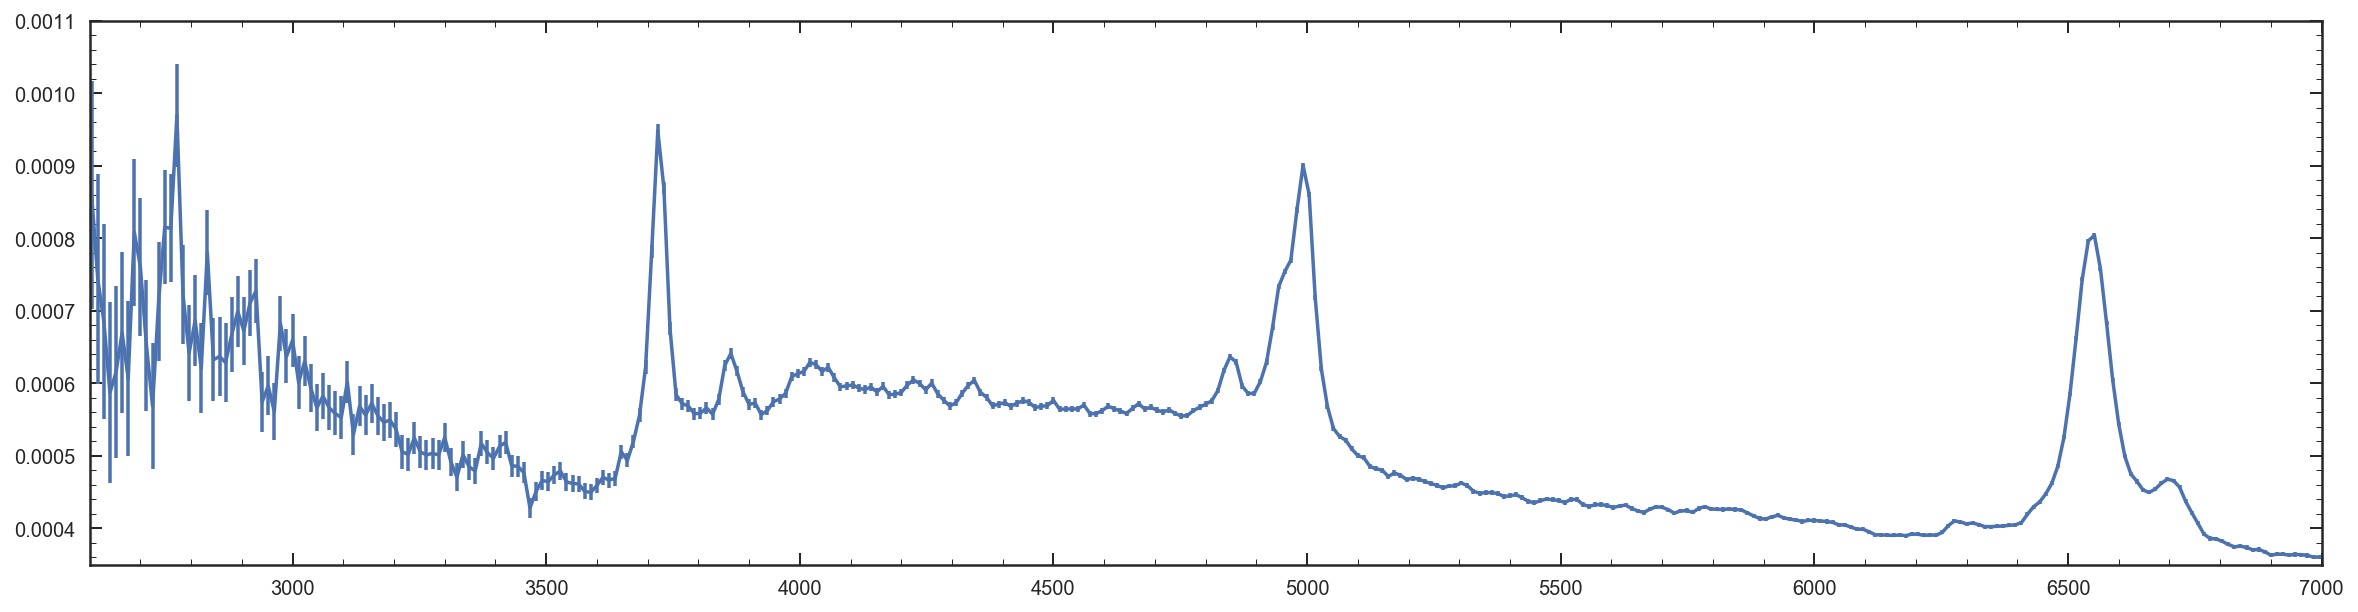

In [215]:
plt.figure(figsize=[20,5])
plt.errorbar(rfwv, stack,error)
plt.xlim(2600,7000)
plt.ylim(0.00035,0.0011)

(1e-19, 6.1e-19)

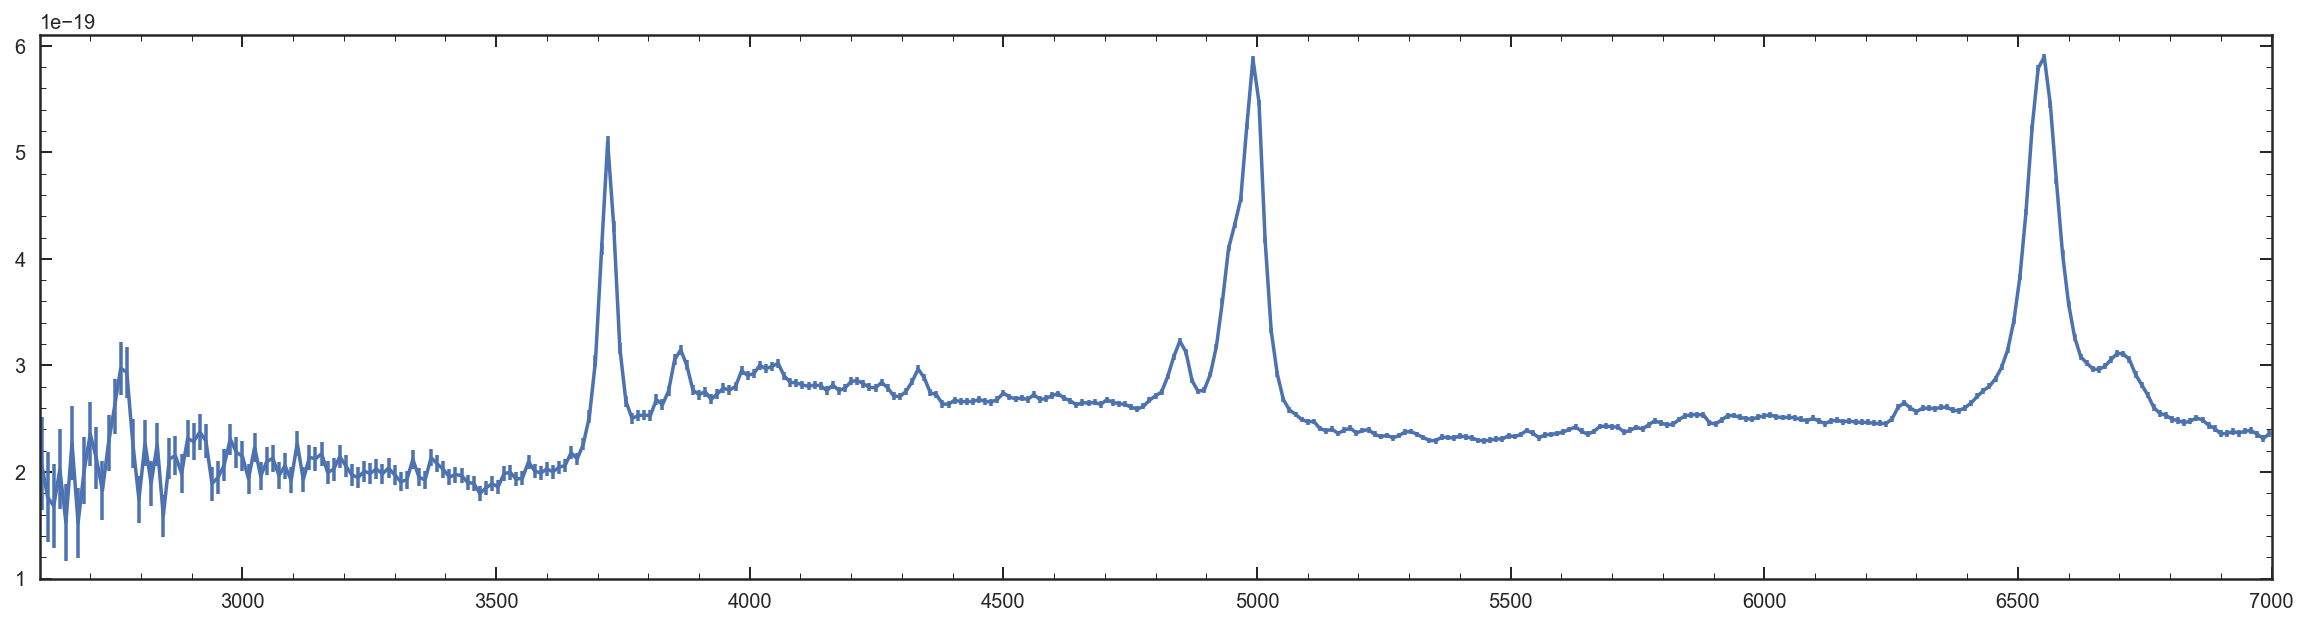

In [221]:
plt.figure(figsize=[20,5])
plt.errorbar(rfwv, stack,error)
plt.xlim(2600,7000)
plt.ylim(1E-19,6.1E-19)